<hr style="height:1px">
<hr style="height:3px">

#   Etsy Data Challenge : Analyzing Food-Mart Data

  **Question # 2** : Investigate avenues for **increasing sales and profitability** and provide the executive team with insights from the data that highlight **growth opportunities**. 
  
  An executive summary should include :
  - the **recommendations** 
  - the **potential impact**  
  - the **data** supporting the strategy

<hr style="height:1px">
<hr style="height:3px">

### Section#1 : Effect of Promotions on the Sales in Food Mart Stores : 

Given the time constraints, I focussed mostly on the **sales - promotion** inter-relationship to answer this question. 

The first section of this notebook documents the analysis performed to determine how **promotions** are affecting the sales and profit figures of Food-Mart stores in the financial year 1997, broken down for the **three families of products** in these stores : 

- Drinks
- Food
- Non-Consumableson 

Starting with some initial exploration of number of promotions and how that affects the total unit_sales as well as profit, I moved on to evolution of monthly sales figures in 1997. 

These were compared to the timeline of promotions for finding correlations. Comparison of number of sales with and without promotions concluded this study.

Effectiveness of different channels of promotions were explored next with regard to how they affect sales and profit.
   
### Section#2 : Clustering analysis applied to stores and customers :

I was also interested in exploring the possibilities of :

1. Clustering the stores into select groups with distinctive patterns of sales/growth

2. Clustering customers into groups with distinct behavior

However, this study seemed to require more time and data than what I had to produce significant results. Nevertheless I was still able to derive some useful insights that I included in this section. 

A link to the **executive** summary of the most important findings from this study has been provided at the end of the notebook.


.
<hr style="height:2px">

In [6]:
# Import the necessary packages

from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn

%matplotlib inline
pd.set_option('notebook_repr_html',False)

In [7]:
# Setting up connection using SQL Alchemy : 

dbname = 'etsy'
username = 'parama'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [8]:
# Setting up connection using Psycopg2 : 

try:
    conn = psycopg2.connect(database = 'etsy', user = 'parama' , password = 'pargop')
except:
    print 'Unable to connect'

## Section - 1
### A. Investigative analysis of Sales & Promotion Data : 

I began with an initial exploration of sales and promotions for different product families and brands. 

In all the cases the total sales (= summing over unit_sales) as well as profit seemed to grow with the number of promotions. The profit seemed to show more scatter but that could just be due to assumptions made in calculating it.

This is a good sign - promotions do indeed affect the total sales!

In [9]:
# SQL query to read in number of promos, total sales and profit

sql_query = """
SELECT a.product_id,a.product_category,a.product_family,
count(b.promotion_id) as no_of_promos,sum(b.unit_sales) as total_sales,
sum(b.profit) as total_profit 
FROM new_product a inner join transactions b ON a.product_id = b.product_id 
where b.promotion_id != 0 
    group by a.product_id, a.product_category, a.product_family 
    order by a.product_family, a.product_category;
"""
s_plot1 = pd.read_sql_query(sql_query,conn)

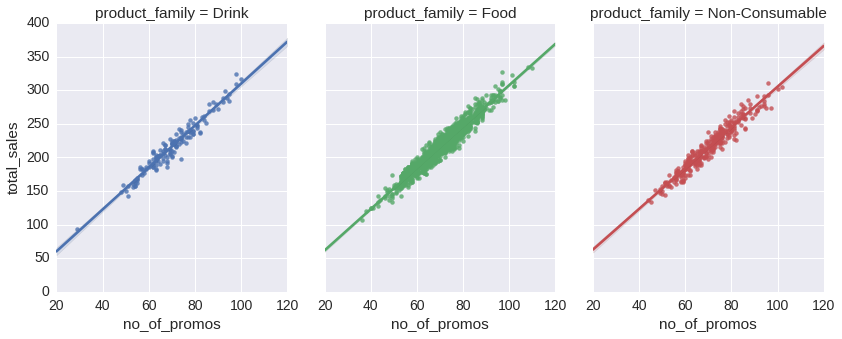

In [10]:
# Plot-1
# No of promotions Vs Total Sales for each unique product id belonging to 3 product classes
sns.set(font_scale=1.4) 
g = sns.lmplot(x="no_of_promos", y="total_sales", hue="product_family", col="product_family",data=s_plot1, aspect = .8)

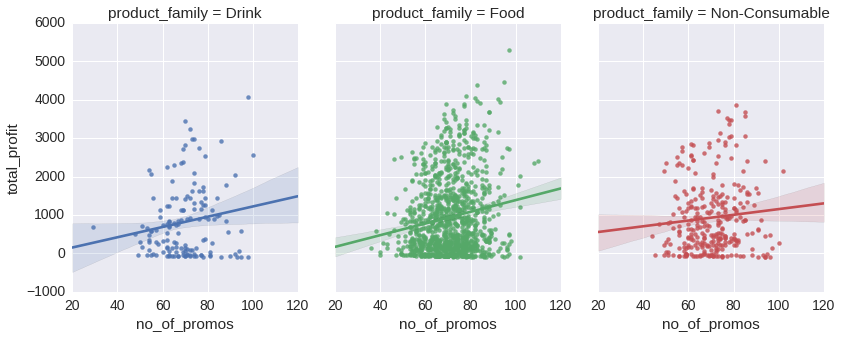

In [11]:
# No of promotions Vs Profit for each unique product
g = sns.lmplot(x="no_of_promos", y="total_profit", hue="product_family", col="product_family",data=s_plot1, aspect = .8)

In [12]:
# Query to read out brandwise information
sql_query = """
SELECT a.product_id,a.brand_name,a.product_family,
count(b.promotion_id) as n_prom,sum(b.unit_sales) as t_sales,
sum(b.profit) as t_profit 
FROM new_product a inner join new_transaction b ON a.product_id = b.product_id 
where b.promotion_id != 0 
    group by a.product_id, a.brand_name, a.product_family 
    order by a.product_family, a.brand_name;
"""
s_plot2 = pd.read_sql_query(sql_query,conn)

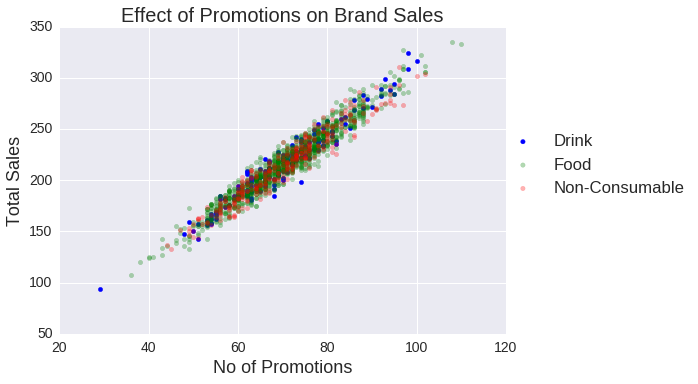

In [13]:
# Plotting No of Promotions Vs Sales for each brand

X1 = s_plot1[s_plot2.product_family=='Drink'].ix[:,3]
Y1 = s_plot1[s_plot2.product_family=='Drink'].ix[:,4]
X2 = s_plot1[s_plot2.product_family=='Food'].ix[:,3]
Y2 = s_plot1[s_plot2.product_family=='Food'].ix[:,4]
X3 = s_plot1[s_plot2.product_family=='Non-Consumable'].ix[:,3]
Y3 = s_plot1[s_plot2.product_family=='Non-Consumable'].ix[:,4]

plt.scatter(X1,Y1,color='blue')
plt.scatter(X2,Y2,color='green',alpha = 0.3)
plt.scatter(X3,Y3,color='red',alpha=0.3)

#plt.xlim(0, 150)
#plt.ylim(0, 500)
plt.xlabel('No of Promotions',size = 18)
plt.ylabel('Total Sales',size=18)
plt.title('Effect of Promotions on Brand Sales',size = 20)
plt.legend(labels=['Drink','Food','Non-Consumable'],loc=9, bbox_to_anchor=(1.2, 0.7),fontsize = 'medium')
#plt.text(0.5, 1.08, plt.title,horizontalalignment='center',fontsize=20)

plt.show()

How do the frequency distributions of total sales or number of promotions look ?

For food category atleast - they look normally distributed.

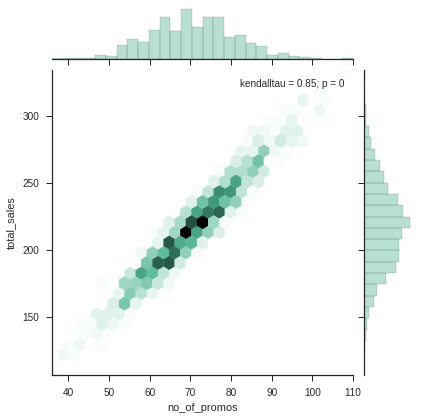

In [14]:
# Interesting visualisation for variable (promo count, total sales) distribution: 
from scipy.stats import kendalltau
sns.set(style="ticks")
sns.jointplot(X2, Y2, kind="hex", stat_func=kendalltau, color="#4CB391")

A deeper dive into the sales and promotion data revealed the following : 

- **The Promotion TimeLine Conundrum**

Sales data only has entries for 1997 but Promotion table has entries starting from 1996 to 1998. 

What makes it confusing is that some sale entries in 1997 used promotions that were offered back in 1996.
These 10 promos (*wallet savers, save-it-sale, fantastic discounts, dollar cutters, price_winners, big_promo, sale winners, savings galore, super duper savers and best savings*) were offered in specific months of 1996 but got used in multiple different months in 1997. 

The following SQL outputs revealed that there were a substantial number of these spurious entries.

- SELECT count(a.\*) FROM promotion a INNER JOIN new_transaction b ON a.promotion_id = b.promotion_id 
    WHERE a.promotion_id != 0 AND customer_id != 0 AND a.start_date < '1997-01-01' ;
 
 *count 
 23174
(1 row)*

- SELECT count(a.\*) FROM promotion a INNER JOIN new_transaction b ON a.promotion_id = b.promotion_id 
    WHERE a.promotion_id != 0 AND customer_id != 0 AND a.start_date > '1997-01-01' ;

 *count 
 22920
(1 row)*

- SELECT count(a.\*) FROM promotion a INNER JOIN new_transaction b ON a.promotion_id = b.promotion_id 
    WHERE a.promotion_id != 0 AND customer_id != 0 ;

 *count 
 46348
(1 row)*


For those parts of analysis where direct effects of promotions are weighed against sales figures we will exclude the spurious entries as we do not have any further information about them at this point. 

For all other analysis where we will explore customer behavior or individual shop characteristics all transaction entries will be considered to ensure we are not loosing data and information.

- **Duration of Promotions**

Distribution of duration of promos revealed most of them to last 1-7 days at most ( except 4 that lasted 29 days) - Since transaction information is monthly - I decided to consider every promotion will affect the sales of the entire month.

Verification : Month of year information from transaction table was compared with the month extracted from start/end_date information in promotion table and they matched. 
    
- **Are most shops offering promotions**

Shops offering/not offering promos revealed only 13 shops not offering any promo vs all the others offering some promo or the other for the entire year.

.

In [ ]:
# Query to extract data for a study of duration of promotions 
# They are mostly 1-7 days with only 4 promos lasting for 29 days
sql_query = """SELECT start_date,end_date,(CAST((end_date) AS date) - CAST((start_date) AS date)) 
                    AS DateDifference FROM promotion ;"""

### B. Time-evolution of sales over months of year : 

 **Total sales** and **profit** data are read in from the SQL database aggregated into 12 months of the year 1997 for three different product families. Again, profit was defined as : 
 
 $$ \rm Profit =   ( \rm Store Sales - \rm Store Cost ) \times ( \rm Unit Sales )   $$
 
In this sub-section, I looked at :
- How total sales vary over the year
- How promotion costs ( - one indicator of number of promotions) vary over the year
- How unpromoted and promoted sales compare

From the first total sales - timeline plot using actual sales value - food sales in general are much larger than sale of drinks/non-consumables. I was more interested in looking at the trends of sales (rise/fall) rather than the actual volume so I decided to look at the normalized (by maximum value) sales figures henceforth.


In [15]:
# SQL query to read in data for the timeline analysis
s_query = """
SELECT a.product_family, b.month_of_year, SUM(b.unit_sales) AS tot_sales, SUM(b.profit) AS tot_profit 
    FROM new_product a INNER JOIN new_transaction b ON a.product_id = b.product_id 
    GROUP BY a.product_family, b.month_of_year 
    ORDER BY a.product_family,b.month_of_year;
"""
sales_data = pd.read_sql_query(s_query,conn)

In [16]:
# Defining a plotting function that makes time evolution plots for 3 product families 
    
def line_compare(data,cno,var):
    x = data[data.product_family == 'Drink'].month_of_year
    y1 = data[data.product_family == 'Drink'].ix[:,cno]
    y2 = data[data.product_family == 'Food'].ix[:,cno]
    y3 = data[data.product_family == 'Non-Consumable'].ix[:,cno]
    labels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
    plt.figure(figsize=(12,6))

    plt.plot(x,y1,marker='o')    
    plt.plot(x,y2,marker='o')    
    plt.plot(x,y3,marker='o')    
    plt.xlabel('Month Of Year',size=15)
    plt.ylabel(var,size=15)
    plt.legend(labels=['Drink', 'Food', 'Non-Consumable'],loc=9, bbox_to_anchor=(1.2, 0.7),fontsize = 'x-large')
    plt.xticks(x, labels)

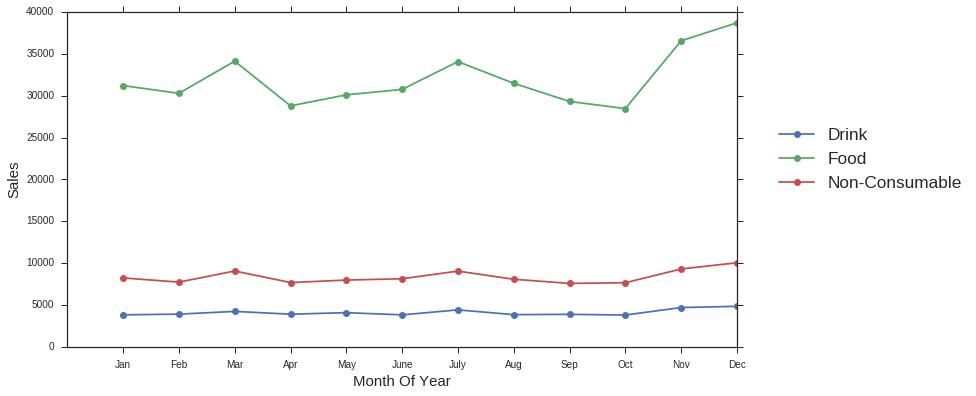

In [17]:
# Plot - 1
# Line plots showing evolution of actual Total Unit Sales in each Product family in 1997
line_compare(sales_data,2,'Sales')

In [18]:
# Define a plotting function for normalized plots : 

def line_compare_n(data,cno,var):              # Plots lines with Normalized data 
    x = data[data.product_family == 'Drink'].month_of_year
    y1 = data[data.product_family == 'Drink'].ix[:,cno]/max(data[data.product_family == 'Drink'].ix[:,cno])
    y2 = data[data.product_family == 'Food'].ix[:,cno]/max(data[data.product_family == 'Food'].ix[:,cno])
    y3 = data[data.product_family == 'Non-Consumable'].ix[:,cno]/max(data[data.product_family == 'Non-Consumable'].ix[:,cno])
    labels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
    plt.figure(figsize=(12,6))

    plt.plot(x,y1,marker='o')    
    plt.plot(x,y2,marker='o')    
    plt.plot(x,y3,marker='o')    
    plt.xlabel('Month Of Year',size=15)
    plt.ylabel('Normalized '+var,size=15)
    plt.legend(labels=['Drink', 'Food', 'Non-Consumable'],loc=9, bbox_to_anchor=(1.2, 0.7),fontsize = 'x-large')
    plt.xticks(x, labels)

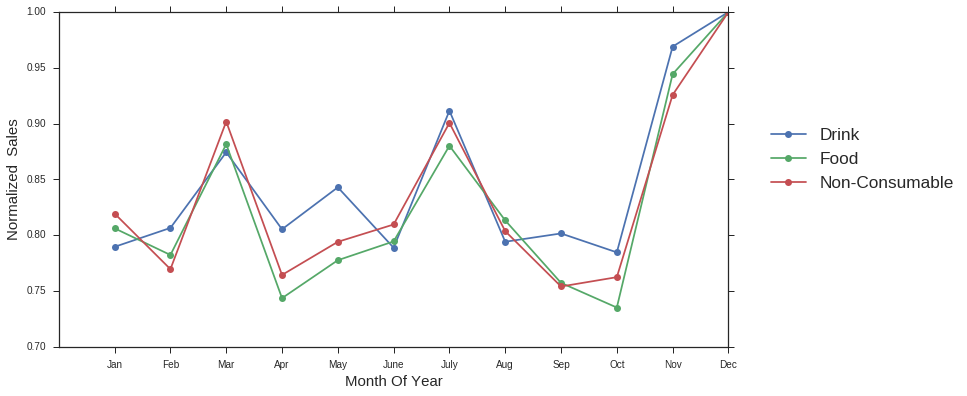

In [19]:
# Plot - 2 (sales with time)
# Normalized values to compare rise and fall evenly
line_compare_n(sales_data,2,' Sales')

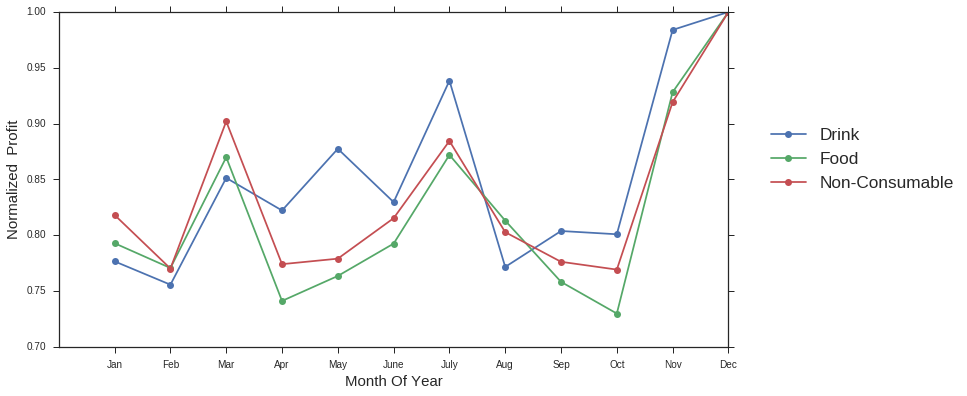

In [20]:
# Plot - 3 (profit with time)
# Normalized values to compare rise and fall evenly
line_compare_n(sales_data,3,' Profit')

From the above two plots : 
- Sales peak in the festive months of November-December and also in March and July.
- Sales of Food and Non-Consumables rise and fall together
- Sales of Drinks appears to fluctuate less compared to others
- Steep fall in sales is seen in : Feb, April, Oct 
- It seems drinks are somewhat a more profitable product than the others - this maybe because the selling price of drinks is larger than the cost price based on the formula we are using - but we can't be totally sure at this point.
Next, I thought it will be interesting to see if promotion curves fit into this pattern in any way. 

The following SQL queries were used to generate tables for the next analysis : 

In [ ]:
# To be run from Console
# Making the p_trans table : only transactions with promotions after 1997 - for further analysis

"""SELECT a.promotion_id,a.promotion_name,a.media_type,a.cost,b.product_id,b.customer_id,b.store_id,
          b.month_of_year,b.unit_sales,b.profit INTO c_promo_trans 
      FROM promotion a INNER JOIN transactions b ON a.promotion_id = b.promotion_id 
         WHERE a.promotion_id !=0 AND a.end_date > '1997-01-01'; """
 
# Making sales without promotions (unpromoted) table : 
    
"""SELECT a.product_family,b.month_of_year,SUM(b.unit_sales) AS up_tsales,SUM(b.profit) AS up_tprofit 
      INTO unpromoted_sales 
        FROM new_product a INNER JOIN new_transaction b ON a.product_id=b.product_id 
      WHERE b.promotion_id = 0 
        GROUP BY a.product_family,b.month_of_year ORDER BY a.product_family,b.month_of_year;"""

# Making sales with correct promotions (after 1997) table : 
    
"""SELECT a.product_family,b.month_of_year,SUM(b.unit_sales) AS p_tsales,SUM(b.profit) AS p_tprofit 
    INTO promoted_sales 
    FROM new_product a INNER JOIN p_trans b ON a.product_id=b.product_id 
     GROUP BY a.product_family,b.month_of_year ORDER BY a.product_family,b.month_of_year;"""

# Making sales with all promotions (1996) table : 

"""SELECT a.product_family,b.month_of_year,SUM(b.unit_sales) AS p6_tsales,SUM(b.profit) AS p6_tprofit 
    INTO promoted66_sales 
    FROM new_product a INNER JOIN transactions b ON a.product_id=b.product_id 
                       INNER JOIN promotion c ON b.promotion_id = c.promotion_id 
        WHERE b.promotion_id != 0 AND c.end_date < '1997-01-01' 
        GROUP BY a.product_family,b.month_of_year ORDER BY a.product_family,b.month_of_year;"""

In [23]:
# Promotion + Sales data read in from SQL
s_query = """
SELECT a.*, b.p6_tsales, b.p6_tprofit,c.up_tsales,c.up_tprofit from promoted_sales a 
    INNER JOIN promoted66_sales b ON a.product_family=b.product_family 
                                AND a.month_of_year = b.month_of_year
    INNER JOIN unpromoted_sales c ON b.product_family = c.product_family
                                AND b.month_of_year = c.month_of_year
    ORDER BY a.product_family,b.month_of_year """

uvp_data = pd.read_sql_query(s_query,conn) # unpromoted vs promoted sales

In [24]:
# Define plotting function to compare two sets of plots:

def line2_compare(data,cno1,cno2,klab,yname):
    x = data[data.product_family == 'Drink'].month_of_year
    y11 = data[data.product_family == 'Drink'].ix[:,cno1]/max(data[data.product_family == 'Drink'].ix[:,cno1])
    y12 = data[data.product_family == 'Food'].ix[:,cno1]/max(data[data.product_family == 'Food'].ix[:,cno1])
    y13 = data[data.product_family == 'Non-Consumable'].ix[:,cno1]/max(data[data.product_family == 'Non-Consumable'].ix[:,cno1])
    y21 = data[data.product_family == 'Drink'].ix[:,cno2]/max(data[data.product_family == 'Drink'].ix[:,cno2])
    y22 = data[data.product_family == 'Food'].ix[:,cno2]/max(data[data.product_family == 'Food'].ix[:,cno2])
    y23 = data[data.product_family == 'Non-Consumable'].ix[:,cno2]/max(data[data.product_family == 'Non-Consumable'].ix[:,cno2])
    labels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
    plt.figure(figsize=(12,6))

    plt.plot(x,y11,marker='o')    # blue = drinks
    plt.plot(x,y12,marker='o')    # green=food
    plt.plot(x,y13,marker='o')    # red = NC
    plt.plot(x,y21,marker='o',linestyle='--')
    plt.plot(x,y22,marker='o',linestyle='--')
    plt.plot(x,y23,marker='o',linestyle='--')
    plt.xlabel('Month Of Year',size=15)
    plt.ylabel(yname,size=15)
    plt.legend(labels=klab,loc=9, bbox_to_anchor=(1.2, 0.7),fontsize = 'x-large')
    plt.xticks(x, labels)

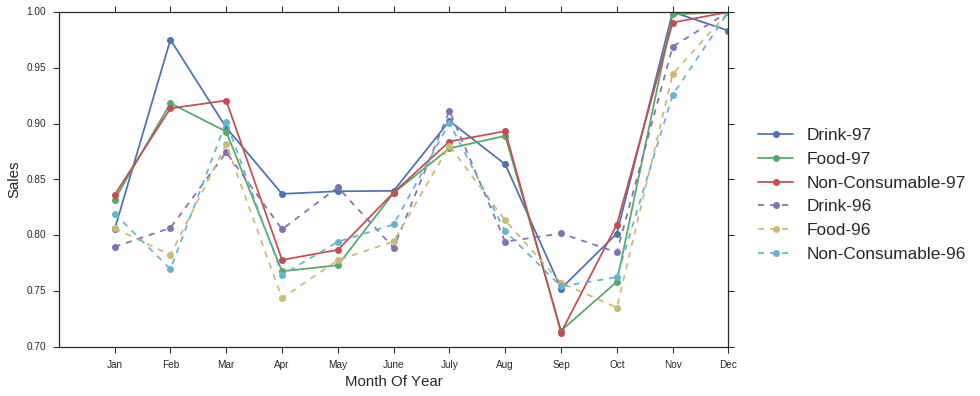

In [25]:
# Plot - 4 (sales with promotions from 1996 Vs sales with promotion from 1997)
# Compare Total Sales using promotions of 96 and 97 separately
labels = ['Drink-97', 'Food-97', 'Non-Consumable-97','Drink-96', 'Food-96', 'Non-Consumable-96']
line2_compare(uvp_data,2,4,labels,'Sales')

I wanted to briefly look at the differences in sales using promos from 1996 (that we are ignoring) and the promos from 1997. 

I found from the above plot that for most of the year the two groups behave similar to each other (except in february)- But its difficult to make any conclusions from this as we dont know what using 1996 promos in 1997 means!

In [26]:
s_query = """
SELECT sub1.product_family, sub1.month_of_year, sub1.promo_cost, sub2.tot_sales, sub2.tot_profit FROM 
    ( SELECT a.product_family,b.month_of_year,SUM(b.cost) AS promo_cost
        FROM new_product a INNER JOIN c_promo_trans b ON a.product_id = b.product_id
        GROUP BY a.product_family,b.month_of_year ORDER BY a.product_family,b.month_of_year) sub1 
    INNER JOIN 
    ( SELECT a.product_family, b.month_of_year, SUM(b.unit_sales) AS tot_sales, SUM(b.profit) AS tot_profit 
        FROM new_product a INNER JOIN new_transaction b ON a.product_id = b.product_id 
        GROUP BY a.product_family, b.month_of_year 
        ORDER BY a.product_family,b.month_of_year) sub2 
    ON sub1.product_family = sub2.product_family AND
        sub1.month_of_year = sub2.month_of_year ; """

cs_data = pd.read_sql_query(s_query,conn) # promotion costs

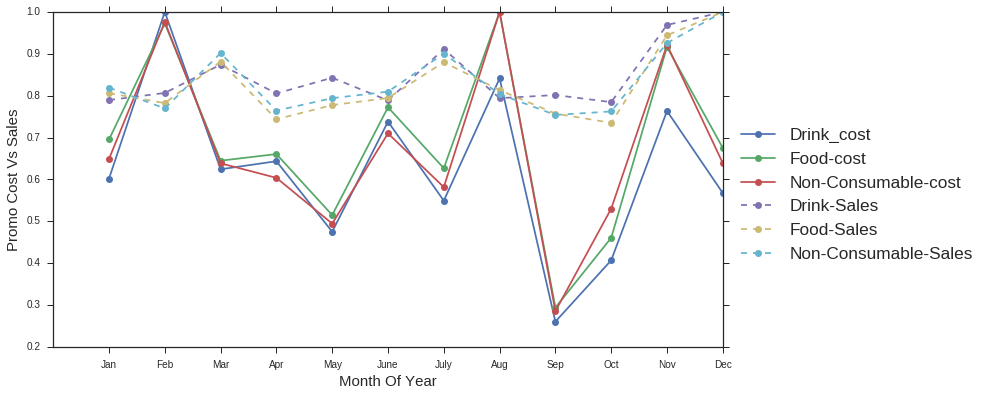

In [27]:
# Plot - 5 (Cost of promotion vs Sales)
labels = ['Drink_cost', 'Food-cost', 'Non-Consumable-cost','Drink-Sales', 'Food-Sales', 'Non-Consumable-Sales']
line2_compare(cs_data,2,3,labels,'Promo Cost Vs Sales')

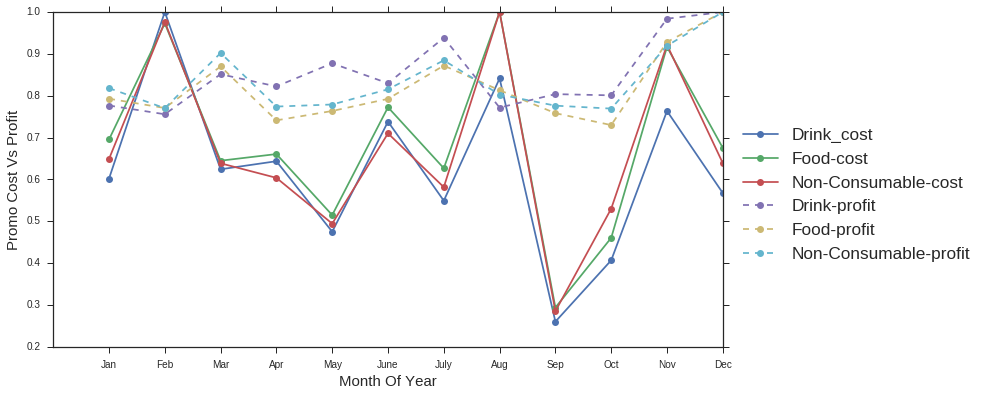

In [28]:
# Plot - 6 (Cost of prmotion vs Profit)
labels = ['Drink_cost', 'Food-cost', 'Non-Consumable-cost','Drink-profit', 'Food-profit', 'Non-Consumable-profit']
line2_compare(cs_data,2,4,labels,'Promo Cost Vs Profit')

Based on the Plots 5 and 6 above : 

- Degree of promotions have greater variations than sales and profit - this is a region with a potential for re-distribution of number of promotions and their costs among different months of the year.

- In the months of large sales :
    - Nov-Dec : promotion was larger in november but not december but sales continued to grow - maybe this is the time of year when customers will buy more because of the festivals irrespective of promotions offered or not.
    - March and July : Promotions were fewer but sales were still high - needs more looking into

- In the months of low sales : 
    - Feb : There were many promotions but sales continued to be low
    - Apr-May : Fewer promotions
    - Sep-Oct : Again very few promotions 

Next I looked at the variations of sales with and without using promotions - I thought this could be used to look at base cases of **customer buying patterns** and answering questions like : are there some months of the year when customers tend to shop more irrespective of promotions or not?

In that case we could maybe move promotions more to those parts of the year when customers shop less in general and the added incentive from promotions could be used to nudge them to make more purchases.

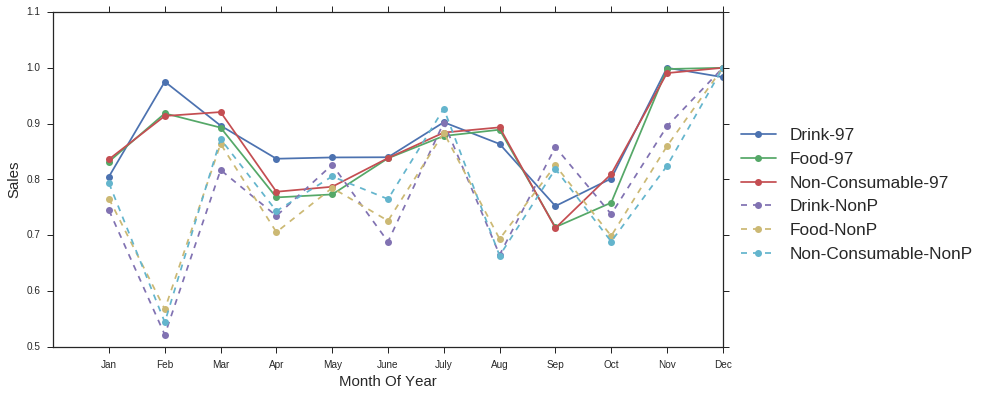

In [29]:
# Plot - 7 (Sales with and without using promotions)
labels = ['Drink-97', 'Food-97', 'Non-Consumable-97','Drink-NonP', 'Food-NonP', 'Non-Consumable-NonP']
line2_compare(uvp_data,2,6,labels,'Sales')

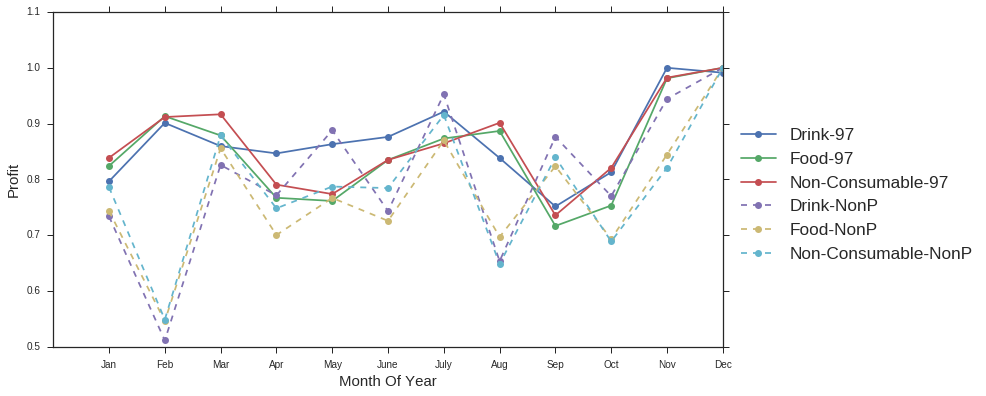

In [30]:
# Plot - 8 (Profit with and without using promotions )
line2_compare(uvp_data,3,7,labels,'Profit')

From the plots 7 and 8 above : 
If the unpromoted sales (sales without using any promotion) are indicative of basic customer behavior - then :

- customers shop less in february - even increasing promotions does not help as we saw before

- July, nov, dec is when customers shop more in general irrespective of promos - Food-Mart promotions are already less in July and Dec - maybe there could be reductions in promotions in november and those could be moved to different month where increasing promotions can be expected to have some effect.

- September is a potential month where promotions could be increased - so far it is less here and unpromoted sales are on a rise this month - showing people generally buy more and could buy even more if promotions be used.

- May is another month when promotions could be increased in an effort to increase sales.

**To summarise** : 
 Promotions in the months of February and November should be cut down and promotions in the months of May and September in particular shoudl be increased. 
 
 February is a month when sales are low and increasing promotions is not helping - there Food-mart could look at other avenues of increasing sales - maybe bring in new products or organize special store events as a way of promoting differently?
 
### C.  Effectiveness of media in promoting sales :

Next I looked at the different media outlets used for promotions and tried to see if any of those were performing better than the others. There were 13 different media types and their combinations that were used for Food-Mart promotions. 

Since I had no information about how the cost/number of promotions were split between the media types when a combination of them were used - I treated the media combinations as a new variable.

This subsection compares the following variables between different media types: 

1. Sales per promotion
2. Profit to promotion cost ratio 

In [31]:
# Query to read in table with media information
s_query = """ SELECT a.product_family, b.media_type, SUM(b.unit_sales) AS t_psales, 
                     SUM(b.cost) AS p_cost,SUM(profit) AS t_pprofit, COUNT(DISTINCT promotion_id) AS n_promos 
           FROM new_product a INNER JOIN c_promo_trans b ON a.product_id = b.product_id 
            GROUP BY a.product_family, b.media_type ORDER BY a.product_family ; """
media_data = pd.read_sql_query(s_query,conn)

In [32]:
# Names of the different media types
media = media_data.ix[:12,1]

In [36]:
# Function to make bar plots:

def media_barplot(data,num,den,yname):              
    
    drink = data[data.product_family == 'Drink'].ix[:,num]/data[data.product_family == 'Drink'].ix[:,den]
    food = data[data.product_family == 'Food'].ix[:,num]/data[data.product_family == 'Food'].ix[:,den]
    nc = data[data.product_family == 'Non-Consumable'].ix[:,num]/data[data.product_family == 'Non-Consumable'].ix[:,den]
    
    x = range(1,14)
    x1 = [i - 0.2 for i in x]
    x2 = [i + 0.2 for i in x]
    plt.figure(figsize=(15,5))
    ax = plt.subplot(111)

    rects1 = ax.bar(x1, drink, width=0.3,color='b',align='center')
    rects2 = ax.bar(x,food,width=0.3,color='g',align='center')
    rects3 = ax.bar(x2,nc,width=0.3,color='r',align='center')
    ax.set_ylabel(yname,fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(media,rotation=60,ha='center')
    axes = plt.gca()
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Drink', 'Food', 'Non-Consumable') )
    #axes.set_ylim([0.0004,0.0018])

    plt.show()      

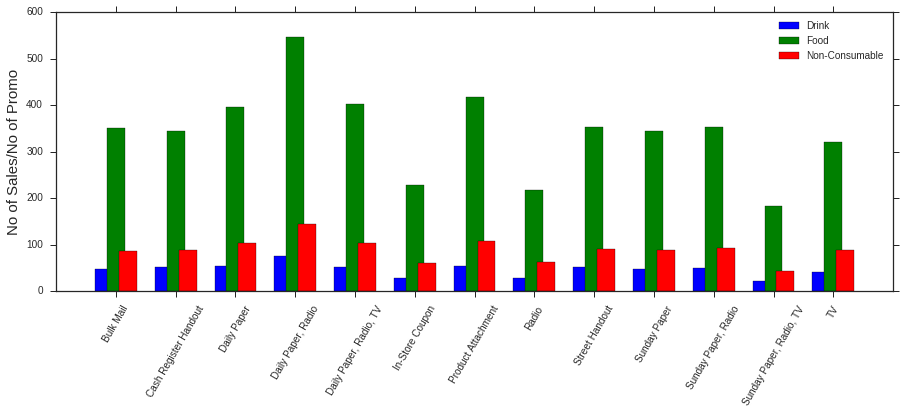

In [37]:
# Plot - 9 
# Ratio of total sales to no of promos for each media outlet : 
media_barplot(media_data,2,5,'No of Sales/No of Promo')

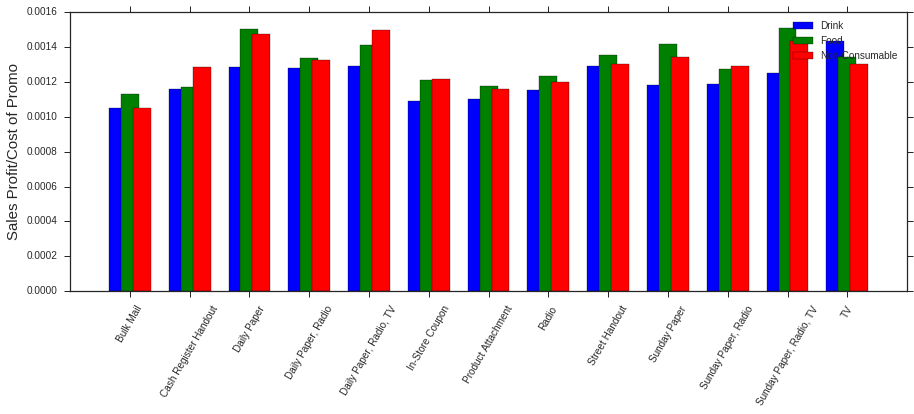

In [38]:
# Plot - 10  ( Ratio of total profit to cost of promos for each media outlet  )
# adjust axis values in function by removing the comment on axes.set_ylim
media_barplot(media_data,4,3,'Sales Profit/Cost of Promo')

For the sales per promo bar chart in Plot 9 : 

- The ratio is meant to give an estimate of the **effectiveness of using promotions** in terms of how many sales per promo can be seen?

- Food products give the best returns, followed by non-consumables, followed by drink - but that could just be due to food sales being much larger in volume than drinks and other categories - It is **food**mart sales that we are talking about!

- Daily Paper + radio combination appears to be doing the best here - Combination of Daily paper with TV, Daily paper itself and product attachments are close seconds
- This implies that Daily paper in itself is the best media channel for promotions
 
- Radio and In-store coupon are doing the worst so far 

I also looked at the **cost-effectivity of the promotions** represented by profit per unit cost of promo - the units of these variables are not clear from the given tables but can still be used for comparison between the media types without going into the actual values of Y-axis.

- In this category, Daily paper performs the best impying it gives the best returns in terms of cost
- TV in combination with Daily and Sunday papers are also cost effective channels of promoting Food-Mart
- Product attachment which had high sales/promo figures appears to be not so effective when costs are considered.

**To summarize** : 

Daily and Sunday papers are most cost-effective media types for promoting products. 
When we looked at how many promotions are being channeled through each media type - (Plot-11 below) it shows that Food-Mart is already putting most of its promotions through Daily paper. 
However there could be some reshuffling done here : 
- product attachment promotions could be reduced and sent to daily paper instead
- cash register handouts seems to be used a lot but they haven't given very high returns so those could be reduced too


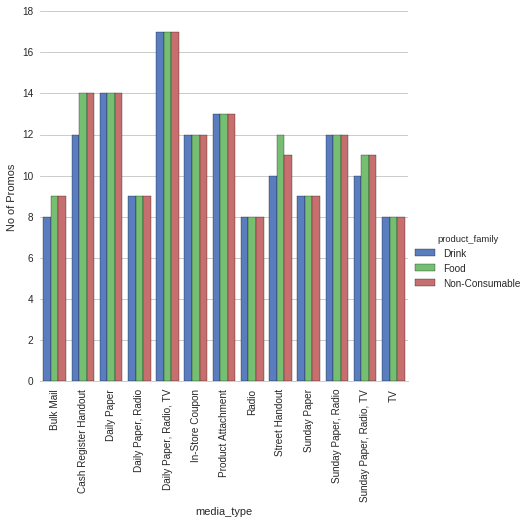

In [40]:
# PLot - 11 (How many promos in each media category)
sns.set(style="whitegrid")
g = sns.factorplot(x="media_type", y="n_promos", hue="product_family", data=media_data,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("No of Promos")
g.set_xticklabels(rotation=90);

<hr style="height:1px">
<hr style="height:1px">

## Section - 2

### A. Analysing Growth opportunities by differentiating between Store Clusters


My aim in this section was to cluster the stores into different groups based on some of their properties like :

- Range/Variety of products sold
- Customer Base
- Departments/Categories of products housed
- Number of promos offered

And how these properties affect sales at the stores.

To start with I looked at the variety of products sold in stores - this revealed that very few stores have the complete range of 1500+ products available. Majority of them have fewer range. This could be due to :

- Some stores are smaller and some are larger stores
- Data is incomplete

For exploratory analysis I also looked at the distribution of number of customers in each store and the total sales in each store. Both the distributions were extremely lop-sided. Implying : 

- Most of the stores have few product, few customers, few sales.

I conclude here that the data is probably incomplete which is also supported by the fact that for **5589 store** id's we have some **5653** unique customer ids - so a combined store-customer analysis may not yield much.

.

In [41]:
# SQL query to read store_data
sql_q = """ select a.store_id,b.product_family,count(distinct a.product_id) as no_products,
                   sum(a.unit_sales) as tsales,sum(a.profit) as profit 
            from new_transaction a inner join new_product b on a.product_id = b.product_id 
            group by a.store_id,b.product_family ; """ 
store_data = pd.read_sql_query(sql_q,conn)

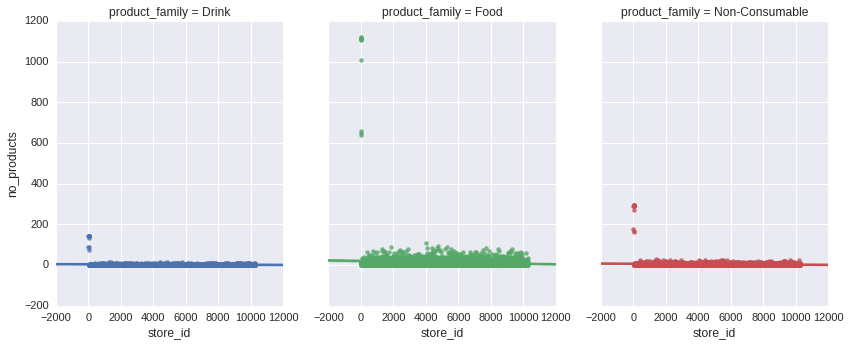

In [42]:
# Plot - 12 (variety of products in stores)
sns.set(font_scale=1.1) 
g = sns.lmplot(x="store_id", y="no_products", hue="product_family", col="product_family",data=store_data, aspect = .8)

In [43]:
sql_query = """
SELECT store_id, COUNT(customer_id) AS no_of_customers, SUM(unit_sales) AS total_sales FROM new_transaction
    GROUP BY store_id;
"""
sc1 = pd.read_sql_query(sql_query,conn)

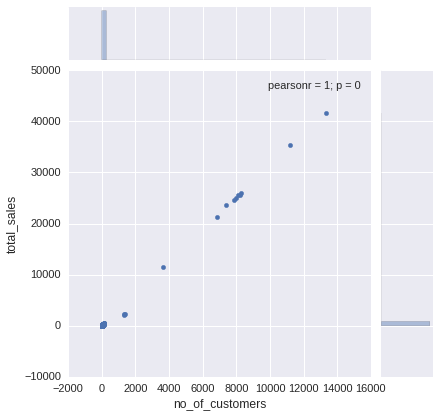

In [44]:
# Plot - 13 (Distribution of no of customers and sales in different stores)
g = sns.jointplot(x="no_of_customers", y="total_sales", data=sc1)

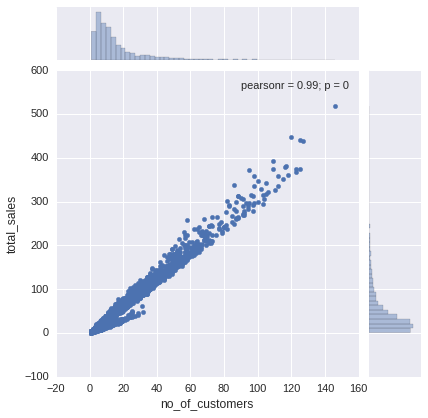

In [45]:
# Plot - 14 : Distribution of customer ans sales in stores with smaller number of customers (<1200)
sc2 = sc1[sc1.no_of_customers<1200]
g = sns.jointplot(x="no_of_customers", y="total_sales", data=sc2)

Clustering stores on the basis of following properties within each product category: 

- No of products
- Sales of Products
- Profit on Products
- No of promos

This is how the store_table data looks :
    store_id | np_drink | sales_drink | profit_drink | npromo_drink |
             |  np_food | sales_food  | profit_food  | npromo_food  |
             |  np_nc   | sales_nc    | profit_nc    | npromo_nc    |

In [46]:
# Query to build a table like described above
sql_query = """ 
  SELECT sub1.*, sub2.np_food, sub2.sales_food, sub2.profit_food, sub2.npromo_food,
                 sub3.np_nc, sub3.sales_nc, sub3.profit_nc, sub3.npromo_nc
            FROM 
( SELECT store_id, COUNT(DISTINCT product_id) AS np_drink, SUM(unit_sales) AS sales_drink, 
                   SUM(profit) AS profit_drink, COUNT(DISTINCT promotion_id) AS npromo_drink FROM pd_transactions
     WHERE product_family = 'Drink' GROUP BY store_id) sub1
            INNER JOIN
( SELECT store_id, COUNT(DISTINCT product_id) AS np_food, SUM(unit_sales) AS sales_food,
                   SUM(profit) AS profit_food, COUNT(DISTINCT promotion_id) AS npromo_food FROM pd_transactions
     WHERE product_family = 'Food' GROUP BY store_id) sub2
            ON sub1.store_id = sub2.store_id
            INNER JOIN
( SELECT store_id, COUNT(DISTINCT product_id) AS np_nc, SUM(unit_sales) AS sales_nc,
                   SUM(profit) AS profit_nc, COUNT(DISTINCT promotion_id) AS npromo_nc FROM pd_transactions
     WHERE product_family = 'Non-Consumable' GROUP BY store_id) sub3
            ON sub2.store_id = sub3.store_id; """
store_data = pd.read_sql_query(sql_query,conn)

In [47]:
# Kmeans clustering to group stores based on their properties
from sklearn.cluster import KMeans
km = KMeans(n_clusters=6)
clus_pred = pd.DataFrame({'cluster':km.fit_predict(store_data.iloc[:,1:13])})

In [48]:
# Size of each cluster
clus_pred['cluster'].value_counts()

0    2995
1       5
4       2
5       1
3       1
2       1
Name: cluster, dtype: int64

In [49]:
clus_pred = pd.concat([clus_pred, store_data.iloc[:,1:13].reset_index(drop= True)], axis = 1)

Clustering with this data was somewhat ineffective as it essentially separated the stores into 10 which have : 
- more sales
- more customers
- more products

and the rest which are either smaller stores or stores with incomplete data.

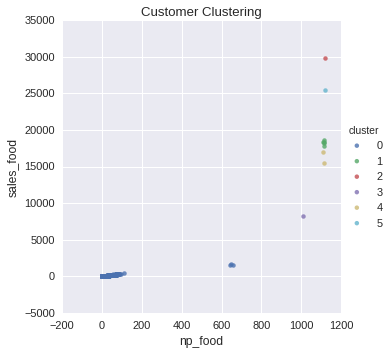

In [50]:
# PLot 15 (Sales of food Vs No of food products)
ax = sns.lmplot(x = 'np_food', y = 'sales_food', 
                data =clus_pred, hue = 'cluster', fit_reg = False);
plt.title('Customer Clustering');

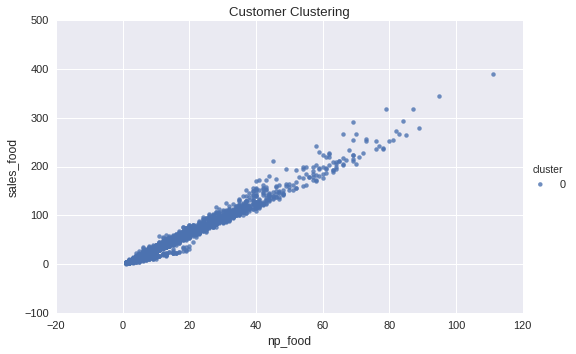

In [58]:
# PLot 16 (Only looking at smaller stores)
data1 = clus_pred[clus_pred.np_food<400]
ax = sns.lmplot(x = 'np_food', y = 'sales_food', data =data1, hue = 'cluster', fit_reg = False, aspect =1.5);
plt.title('Customer Clustering');

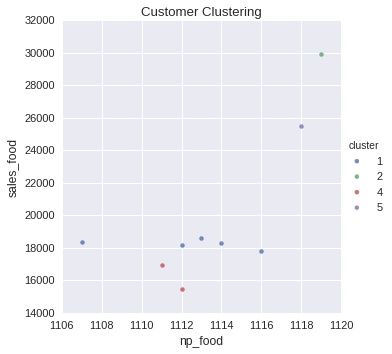

In [52]:
# PLot 17 (Only looking at larger stores)
data1 = clus_pred[clus_pred.np_food>1050]
ax = sns.lmplot(x = 'np_food', y = 'sales_food', data =data1, hue = 'cluster', fit_reg = False);
plt.title('Customer Clustering');

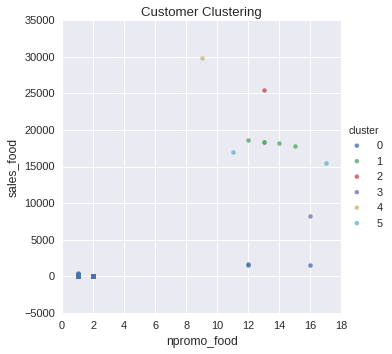

In [52]:
# Plot 18 : For the larger stores - how have promos affected sales
#data1 = clus_pred[clus_pred.np_food>1050]
data1 = clus_pred
ax = sns.lmplot(x = 'npromo_food', y = 'sales_food', data =data1, hue = 'cluster', fit_reg = False);
plt.title('Customer Clustering');

In [55]:
# Largest stores in terms of sales, products housed
sql_query = """SELECT store_id,sum(unit_sales) as sales, count(distinct product_id) as n_prod , 
count(distinct promotion_id) as npromo, count(distinct customer_id) as ncust
                FROM new_transaction GROUP BY store_id ORDER BY sales desc limit 13; """
large_store = pd.read_sql_query(sql_query,conn)

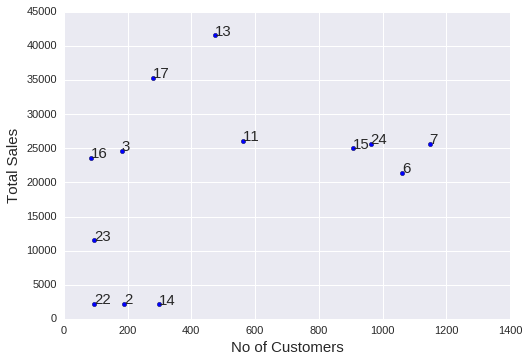

In [61]:
# Plot - 19(a)
# Looking more closely at the large stores performance :

y= large_store.sales
z= large_store.ncust
n= large_store.store_id

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]), size = 15)
    
plt.xlabel('No of Customers',size = 15)
plt.ylabel('Total Sales',size=15)
#plt.title('Effect of Promotions on Brand Sales',size = 20)
#plt.legend(labels=['Drink','Food','Non-Consumable'],loc=9, bbox_to_anchor=(1.2, 0.7),fontsize = 'medium')

Cluster analysis did not help much with the store data as it was only able to capture the large imbalance in stores. 

    sql_query = SELECT store_id,sum(unit_sales) as sales, count(distinct product_id) as n_prod 
                FROM new_transaction GROUP BY store_id ORDER BY sales desc;

Using the above Query I identified **13 Stores** that have larger customer base, larger product sales than the others - these can be identified as : ** Store-13, 17, 11, 7, 24, 15, 3, 16, 6, 23, 2, 22, 14** They have almost the whole variety of products that Food Mart chain carries.

Stores - 2, 22 and 14 are intermediate stores - these could be further expanded to increase sales.

Smaller stores only have about 6% of the total range of products.


Assuming that the two classes of stores are indeed small and large super stores - I looked at their sales vs number of products separately in PLots 16 and 17.

For the smaller stores : 
- Growth in sales with increase in number of products was linear
- There appeared to be a small number of stores housing between 1-20 products that did not do as well as the others (this is seen in the Plot-16 as a small outgrowth from the bottom of the plot)

For the larger stores : 
- Growth in sales with increase in number of products was exponential
- However they are already selling the maximum range of products available - so in their case increase in sales can only be affected by promotions 
    - This is explored in Plot - 17
    - It may be seen that there are two stores with fewer promos that are doing much better than some others.
    - This needs further analysis into the individual stores that is beyond the scope of my study
- I also looked at the number of customers visiting these stores vs the total sales to determine if there are stores where lots of people visit but dont buy much, or vice versa.
    - This is explored in Plot - 18
    - There are three stores (**Store_Id 13, 17, 11**) that have half of the customer base compared to the others and yet show very high sales. 
    - These ideal stores could be looked into to get more insights as to how sales in the other larger stores can also be increased learning from them.


<hr style="height:1px">
<hr style="height:1px">



### B. Clustering customers based on buying patterns :

I tried to cluster customers into different groups based on the following properties : 

- No of products purchases
- No of unique products purchased
- No of stores visited
- No of promotions used
- Total units purchased (sales)
- Which month of the year maximum purchases were made in ?
- Which product family (drink/food/grocery) were purchases made in ?
- Which media did most of the promotions used came from ?


In [56]:
# List of queries used to build the final table : 
sql_query = """
SELECT customer_id,COUNT(product_id) AS n_prod,COUNT(DISTINCT product_id) AS n_uprod, COUNT(DISTINCT store_id) AS n_stores,
    COUNT(promotion_id) AS n_promo, SUM(unit_sales) AS t_sales 
    FROM new_transaction WHERE customer_id != 0
         GROUP BY customer_id ;
"""
cc1 = pd.read_sql_query(sql_query,conn)

# Create intermediate table cc2 (in console):
sql_query = """
select customer_id, month_of_year, sum(unit_sales) as purchase into cc2 from new_transaction 
where customer_id != 0 
group by customer_id, month_of_year order by customer_id, purchase desc;"""

sql_query = """
SELECT a.customer_id, a.month_of_year AS mx_pmonth
FROM cc2 a
INNER JOIN (
    SELECT customer_id, MAX(purchase) pur
    FROM cc2
    GROUP BY customer_id
) b ON a.customer_id = b.customer_id AND a.purchase = b.pur
    ORDER BY customer_id;
    
"""
cc3 = pd.read_sql_query(sql_query,conn)

# Create intermediate table cc3 (in console):
sql_query = """ 
Select a.customer_id, b.product_family, sum(a.unit_sales) as purchase into cc4 
    from new_products b inner join new_transaction a on a.product_id = b.product_id 
        where a.customer_id != 0 
            group by a.customer_id, b.product_family order by a.customer_id, purchase desc; """ 

sql_query = """
SELECT a.customer_id, 
case when a.product_family ='Drink' then 1 when a.product_family = 'Food' then 2 else 3 end AS mx_pf_no 
FROM cc4 a
INNER JOIN (
    SELECT customer_id, MAX(purchase) pur
    FROM cc4
    GROUP BY customer_id
) b ON a.customer_id = b.customer_id AND a.purchase = b.pur
    ORDER BY customer_id;
    
"""
cc5 = pd.read_sql_query(sql_query,conn)

# Create intermediate table cc4 (in console):
sql_query = """ 
select customer_id, media_type, sum(unit_sales) as purchase into cc6 
    from all_p_trans 
        where customer_id != 0 
            group by customer_id, media_type order by customer_id, media_type;"""

sql_query = """
SELECT a.customer_id, 
case when a.media_type ='Bulk Mail' then 1
     when a.media_type ='Cash Register Handout' then 2
     when a.media_type ='Daily Paper' then 3
     when a.media_type ='Daily Paper, Radio' then 4
     when a.media_type ='Daily Paper, Radio, TV' then 5 
     when a.media_type ='In-Store Coupon' then 6
     when a.media_type ='Product Attachment' then 7
     when a.media_type ='Radio' then 8
     when a.media_type ='Street Handout' then 9
     when a.media_type ='Sunday Paper' then 10
     when a.media_type ='Sunday Paper, Radio' then 11
     when a.media_type ='Sunday Paper, Radio, TV' then 12
     when a.media_type ='TV' then 13 end AS n_mmedia
FROM cc6 a
INNER JOIN (
    SELECT customer_id, MAX(purchase) pur
    FROM cc6
    GROUP BY customer_id
) b ON a.customer_id = b.customer_id AND a.purchase = b.pur
    ORDER BY customer_id;
    
"""
cc7 = pd.read_sql_query(sql_query,conn)

In [ ]:
# Putting tables into database
tstrname = ['cc1','cc3','cc5','cc7']
tname = [cc1,cc3,cc5,cc7]
for index in range(4):    
    tname[index].to_sql(tstrname[index].engine)

In [61]:
sql_query = """
SELECT cc1.*,cc3.mx_pmonth,cc5.mx_pf_no,cc7.n_mmedia from from cc1 
inner join cc3 on cc1.customer_id = cc3.customer_id 
inner join cc5 on cc3.customer_id = cc5.customer_id 
inner join cc7 on cc5.customer_id = cc7.customer_id;    
"""
df = pd.read_sql_query(sql_query,conn)

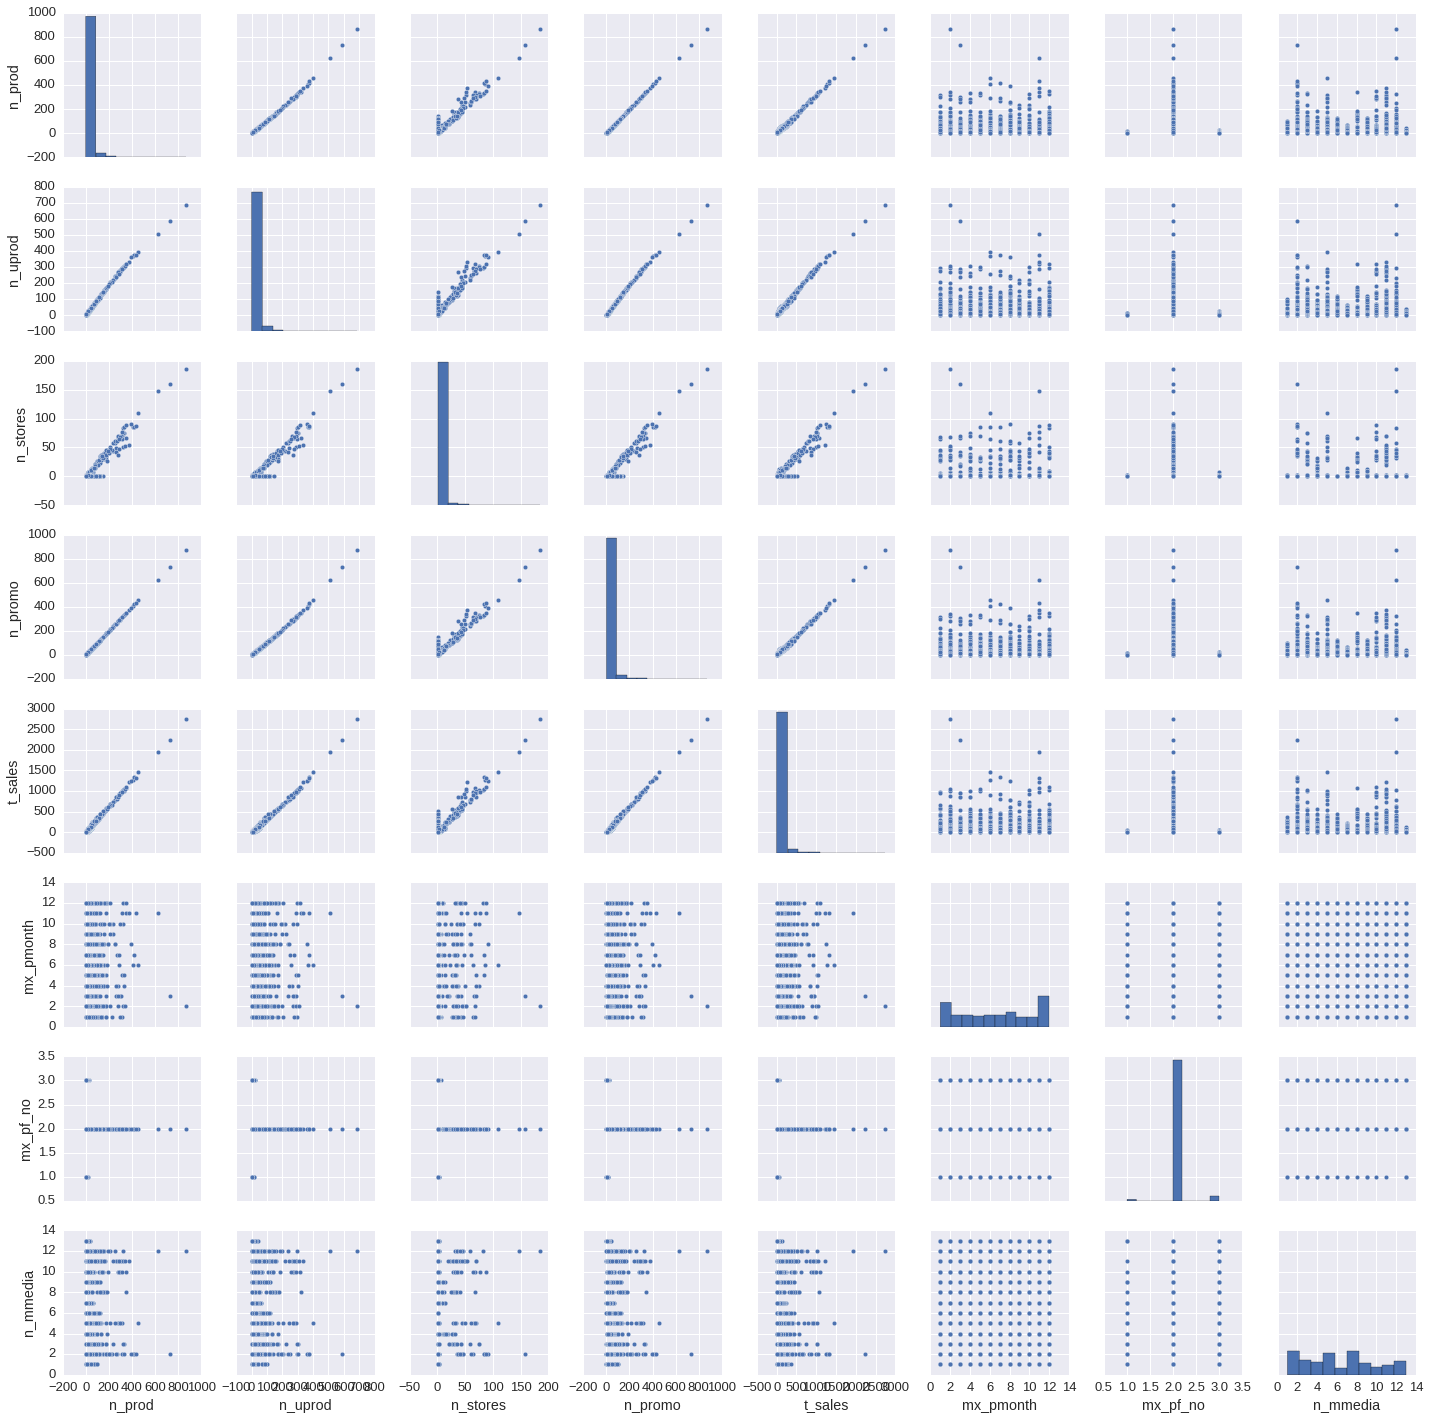

In [72]:
# Plot - 20 (relationship between various customer variables)

sns.set(font_scale=1.3)
sns.pairplot(df.iloc[:,2:10])

What can be said about the customer buying patterns : 

- Most of the customers make maximum purchases in jan and dec
- Food products have the largest buyer base
- Customers have used most number of promotions published through Daily Paper, Bulk email and In store coupon

In [63]:
# Clustering customers using KMeans Clustering method:

from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
df1 = df.iloc[:,2:10]
clus_pred = pd.DataFrame({'cluster':km.fit_predict(df1)})

In [64]:
# How large are the clusters?
clus_pred['cluster'].value_counts()

0    2668
2     752
1     116
3      34
Name: cluster, dtype: int64

In [65]:
clus_pred = pd.concat([clus_pred, df1.reset_index(drop= True)], axis = 1)

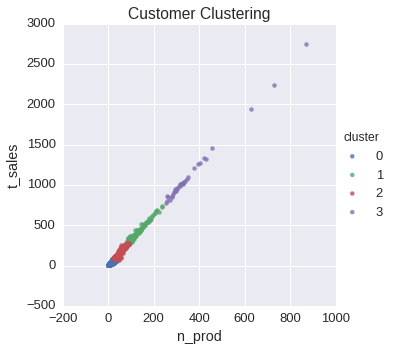

In [73]:
# Plot - 21 (No of unique products purchased vs total unit sales)
ax = sns.lmplot(x = 'n_prod', y = 't_sales', data =clus_pred, hue = 'cluster', fit_reg = False, y_jitter=.5);
plt.title('Customer Clustering');

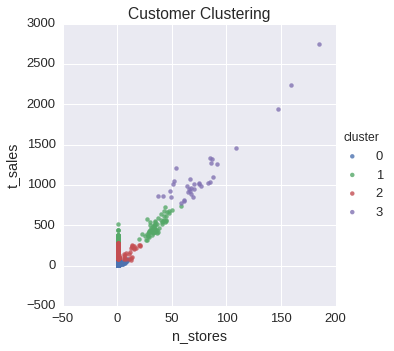

In [74]:
# Plot - 22 (No of stores visited vs total sales )
# data1 = clus_pred[clus_pred.n_stores<50]
data1 = clus_pred
ax = sns.lmplot(x = 'n_stores', y = 't_sales', data =data1, hue = 'cluster', fit_reg = False);
plt.title('Customer Clustering');

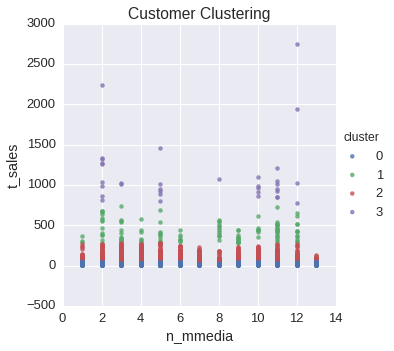

In [71]:
# Plot - 23(Maximum used media type vs total sales)
#data1 = clus_pred[clus_pred.n_stores<50]

data1 = clus_pred
ax = sns.lmplot(x = 'n_mmedia', y = 't_sales', data =data1, hue = 'cluster', fit_reg = False);
plt.title('Customer Clustering');

Clustering analysis of Customers suggests the following patterns of behavior : 

- Clustering seems to have occured mainly on the basis of number of unique products purchased which is also proportional to total sales (Plot-21). 
    - Based on the cluster size - it may be concluded that a large majority of customers (2668) are buying very little and contributing very little to the total revenue. 
    - Very few (34) are purchasing many unique products and in large quantities. 
    
- In plot-22 a comparison is made between the number of stores visited vs number of purchases made. 
    - This reveals that while our large buyers are buying from different stores - there are a group of loyal buyers some of whom contribute largely to the sales and some who don't
    - These low buying loyal customers could be a target for promotions - since they are loyal to the store - they may want to buy more given te incentive
    
- Plot-23 shows how different customer clusters are distributed across different promotion media types based on total sales. 
    - While most of the low spending customers use all the media channels equally - the high buyers show a preference for Cash register handouts and different combinations of daily paper, radio, tv and sunday paper.

    

In [ ]:
# Start server to open the executive summary document 
! python -m SimpleHTTPServer 7000

Serving HTTP on 0.0.0.0 port 7000 ...


[Executive Summary of the Analysis](index.html)

http:localhost:7000/index.html